# Coordinates

Explore the coordinates file for the double resolution run:
* look at the coordinates file that Susan created for the 2022 experiment
* check the coordinates in the lower Fraser River are re: Michael's grid refinements there
* investigate adding coordinate rows at the south edge of the domain to fully include the south
  coastline of Puget Sound and add a sufficient land buffer for OceanParcels to work correctly in 
  that area re: Jose's findings about particle losses at water boundaries

Construct new 202405 coordinates file for future SalishSeaCast hindcast/production:
* add coordinate rows at the south edge of the domain to fully include the south
  coastline of Puget Sound and add a sufficient land buffer for OceanParcels to work correctly
* add meta data to variables guided by
  https://salishsea.eos.ubc.ca/erddap/info/ubcSSn2DMeshMaskV21-08/index.html
* add notes to https://github.com/SalishSeaCast/grid/blob/main/README.rst to document at least some
   files in the `grid` repository


Transform 202405 coordinates file to double resolution for the 2024 experiment:
* follow Susan's process in
  https://github.com/SalishSeaCast/tools/blob/main/double_resolution/coordinates.ipynb

In [96]:
from pathlib import Path
import sys
import warnings

import arrow
import h5netcdf
import numpy
import matplotlib
import matplotlib.pyplot as plt
import scipy
import scipy.optimize
import xarray

Python and library versions:

In [3]:
print(f"Python {sys.version=}")
print(f"{numpy.__version__=}")
print(f"{xarray.__version__=}")
print(f"{h5netcdf.__version__=}")
print(f"{scipy.__version__=}")
print(f"{matplotlib.__version__=}")

Python sys.version='3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:38:13) [GCC 12.3.0]'
numpy.__version__='1.26.4'
xarray.__version__='2024.3.0'
h5netcdf.__version__='1.3.0'
scipy.__version__='1.13.0'
matplotlib.__version__='3.8.4'


In [4]:
# isolate the probable user-specific part of repo paths to make the notebook portable
repos_prefix = Path("/media/doug/warehouse/MEOPAR/")

coords_paths = {
    "sea_202206": repos_prefix / "grid" / "coordinates_SalishSea_double_202206.nc",
    "ssc_201702": repos_prefix / "grid" / "coordinates_seagrid_SalishSea201702.nc",
    "djl_202405": repos_prefix / "grid" / "coordinates_SalishSeaCast_202405.nc",
}

## Look at 2022 Experiment Coordinate File

This coordinates file was crated by the https://github.com/SalishSeaCast/tools/blob/main/double_resolution/coordinates.ipynb notebook.

In [5]:
sea_202206_coords = xarray.open_dataset(coords_paths["sea_202206"])

sea_202206_coords

<xarray.Dataset> Size: 206MB
Dimensions:  (y: 1796, x: 796, time: 1)
Coordinates:
  * y        (y) int64 14kB 0 1 2 3 4 5 6 ... 1789 1790 1791 1792 1793 1794 1795
  * x        (x) int64 6kB 0 1 2 3 4 5 6 7 8 ... 788 789 790 791 792 793 794 795
  * time     (time) int64 8B 0
Data variables: (12/18)
    nav_lat  (y, x) float64 11MB ...
    nav_lon  (y, x) float64 11MB ...
    glamt    (time, y, x) float64 11MB ...
    glamu    (time, y, x) float64 11MB ...
    glamv    (time, y, x) float64 11MB ...
    glamf    (time, y, x) float64 11MB ...
    ...       ...
    e1v      (time, y, x) float64 11MB ...
    e1f      (time, y, x) float64 11MB ...
    e2t      (time, y, x) float64 11MB ...
    e2u      (time, y, x) float64 11MB ...
    e2v      (time, y, x) float64 11MB ...
    e2f      (time, y, x) float64 11MB ...
Attributes:
    acknowledgements:      from Michael Dunphys 201702 stretched river coordi...
    creator_email:         sallen@eoas.ubc.ca
    creator_name:          Salish Sea MEOPAR Project Contributors
    creator_url:           https://salishsea-meopar-docs.readthedocs.org/
    institution:           UBC EOAS
    institution_fullname:  Earth, Ocean & Atmospheric Sciences, University of...
    summary:               Coordinate file, doubled from 201702 coordinates
    source:                tools/double_resolution/coordinates.ipynb
    history:               [2022-06-15] File creation.

* the value of the `time` coordinate is irrelevant,
  but NEMO requires it to exist

* coordinates are concerned only with the y-x plane of the 3d model grid
  
* `nav_lat` and `nav_lon` are the map coordinates of the `(y, x)` grid points
* `glam[tuvf]` are the longitudes of the T, U, V, and F (Vorticity) points in the grid cells
  * `glamt == nav_lon`
* `gphi[tuvf]` are the latitudes of the T, U, V, and F (Vorticity) points in the grid cells
  * `gphit == nav_lat`
* `e1[tuvf]` are the grid spacings in the `u (x)` direction
* `e2[tuvf]` are the grid spacings in the `v (y)` direction
* `tuvf` are the T, U, V, and Vorticity points in the grid cells
* the T point is at the centre of the grid cell
* the U point is at the centre of the north side of the grid cell
* the V point is at the centre of the east side of the grid cell
* the F point is at the north-east corner of the grid cell
* see the [NEMO book](https://epic.awi.de/id/eprint/39698/1/NEMO_book_v6039.pdf), 
  or https://salishseacast.slack.com/archives/CFR6VU70S/p1714601537269469

## Look at Grid Cells in the Lower Fraser River Region

In [6]:
pnw_coast_paths = {
    "coastline": Path("/ocean/rich/more/mmapbase/bcgeo/PNW.mat"),
    "rivers": Path("/ocean/rich/more/mmapbase/bcgeo/PNWrivers.mat"),
}

In [7]:
scipy.io.loadmat(pnw_coast_paths["coastline"])

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Wed Dec 13 21:08:59 2017',
 '__version__': '1.0',
 '__globals__': [],
 'k': array([[      1],
        [ 396666],
        [ 639200],
        ...,
        [1471473],
        [1471478],
        [1471483]], dtype=int32),
 'Area': array([[6.64963493e+01, 3.95526325e+00, 3.52782303e-02, ...,
         2.78499441e-09, 6.50091288e-09, 1.68474882e-09]]),
 'ncst': array([[          nan,           nan],
        [-127.63646203,   52.0126776 ],
        [-115.        ,   52.0126    ],
        ...,
        [-127.55036802,   50.09175668],
        [-127.55045351,   50.0917396 ],
        [          nan,           nan]]),
 'data_source': array(['The Pacific North-West coastline in PNW.mat was created from   ',
        'two sources:                                                   ',
        ' a) BC Freshwater Atlas Coastline (FWCSTLNSSP) available as an ',
        '    Arcview shapefile from GeoBC, and                          ',
      

In [8]:
coastline = scipy.io.loadmat(pnw_coast_paths["coastline"])["ncst"]

In [9]:
scipy.io.loadmat(pnw_coast_paths["rivers"])

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Thu Jun 10 11:15:52 2021',
 '__version__': '1.0',
 '__globals__': [],
 'Area': array([[-8.18986691e-03, -1.43578909e-02, -1.16597842e-03, ...,
         -4.71394438e-08, -2.40930780e-07,  4.52793887e-08]]),
 'k': array([[     1],
        [ 53308],
        [ 79441],
        ...,
        [974172],
        [974180],
        [974188]], dtype=int32),
 'ncst': array([[          nan,           nan],
        [-120.30600682,   53.37489399],
        [-120.30613441,   53.37500507],
        ...,
        [-126.65635942,   52.37805851],
        [-126.65597911,   52.37804142],
        [          nan,           nan]])}

In [10]:
rivers = scipy.io.loadmat(pnw_coast_paths["rivers"])["ncst"]

Visualize the grid "warping" that Michael did to increase resolution in the Fraser River.
Plot grid cells in the Fraser delta region by plotting lines through F points
(north-east corners of cells).

(49.0, 49.3)

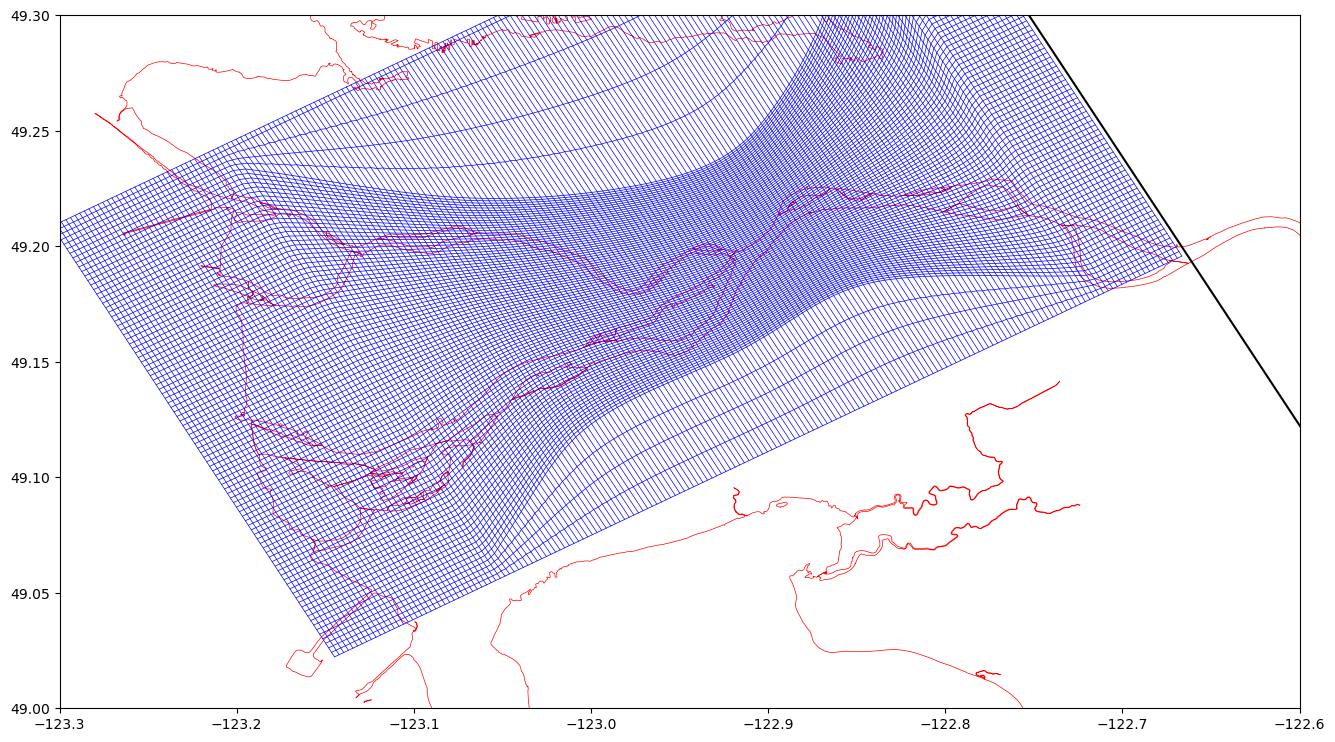

In [11]:
glamf, gphif = sea_202206_coords.glamf[0], sea_202206_coords.gphif[0]

fig, ax = plt.subplots(1, 1, figsize=(16, 9))
ax.plot(coastline[:, 0], coastline[:, 1], color="red", linewidth=0.5)
ax.plot(rivers[:, 0], rivers[:, 1], color="red", linewidth=0.5)

# SalishSeaCast domain boundaries
ax.plot(glamf[0, :], gphif[0, :], color="black")  # south
ax.plot(glamf[:, 0], gphif[:, 0], color="black")  # west
ax.plot(glamf[-1, :], gphif[-1, :], color="black")  # north
ax.plot(glamf[:, -1], gphif[:, -1], color="black")  # east

ax.plot(glamf[800:896, 610:-1], gphif[800:896, 610:-1], color="blue", linewidth=0.5)
for row in range(800, 896):
    ax.plot(glamf[row, 610:-1], gphif[row, 610:-1], color="blue", linewidth=0.5)

# Fraser delta
ax.set_xlim(-123.3, -122.6)
ax.set_ylim(49, 49.3)

Zoom to the section of the river near New Westminster:

(49.15, 49.25)

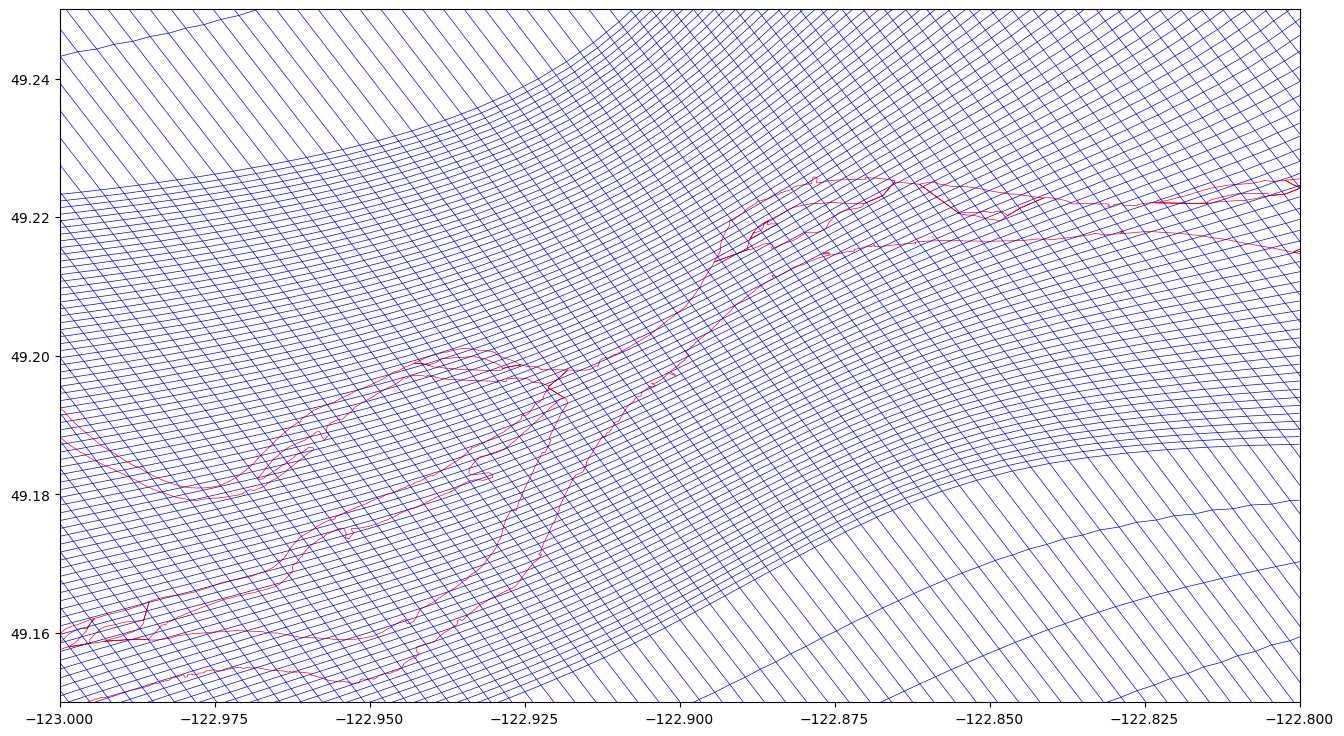

In [12]:
glamf, gphif = sea_202206_coords.glamf[0], sea_202206_coords.gphif[0]

fig, ax = plt.subplots(1, 1, figsize=(16, 9))
ax.plot(coastline[:, 0], coastline[:, 1], color="red", linewidth=0.5)
ax.plot(rivers[:, 0], rivers[:, 1], color="red", linewidth=0.5)

# SalishSeaCast domain boundaries
ax.plot(glamf[0, :], gphif[0, :], color="black")  # south
ax.plot(glamf[:, 0], gphif[:, 0], color="black")  # west
ax.plot(glamf[-1, :], gphif[-1, :], color="black")  # north
ax.plot(glamf[:, -1], gphif[:, -1], color="black")  # east

ax.plot(glamf[800:896, 610:-1], gphif[800:896, 610:-1], color="blue", linewidth=0.5)
for row in range(800, 896):
    ax.plot(glamf[row, 610:-1], gphif[row, 610:-1], color="blue", linewidth=0.5)

# Fraser delta
# ax.set_xlim(-123.3, -122.6)
# ax.set_ylim(49, 49.3)

# Zoom
ax.set_xlim(-123.0, -122.8)
ax.set_ylim(49.15, 49.25)

## Look at the South Edge of the Grid

(47.0, 47.3)

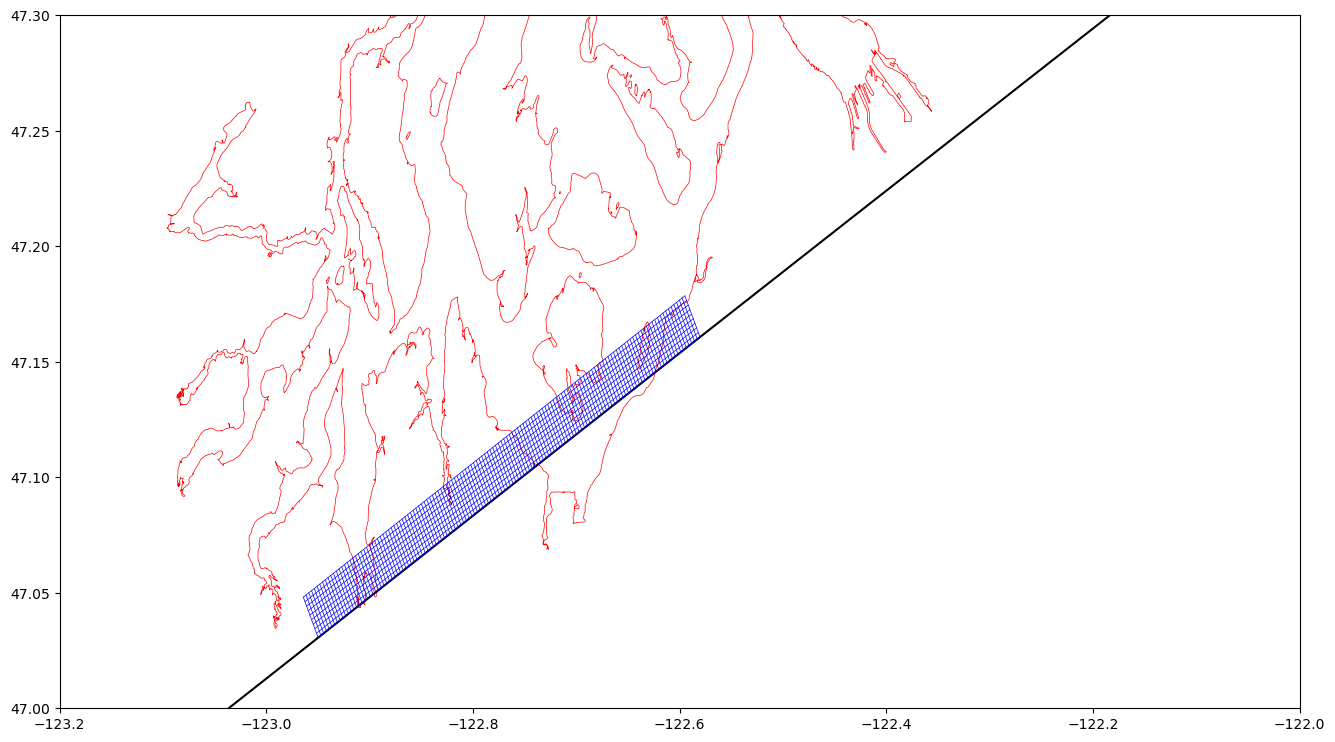

In [13]:
glamf, gphif = sea_202206_coords.glamf[0], sea_202206_coords.gphif[0]

fig, ax = plt.subplots(1, 1, figsize=(16, 9))
ax.plot(coastline[:, 0], coastline[:, 1], color="red", linewidth=0.5)
ax.plot(rivers[:, 0], rivers[:, 1], color="red", linewidth=0.5)

# SalishSeaCast domain boundaries
ax.plot(glamf[0, :], gphif[0, :], color="black")  # south
ax.plot(glamf[:, 0], gphif[:, 0], color="black")  # west
ax.plot(glamf[-1, :], gphif[-1, :], color="black")  # north
ax.plot(glamf[:, -1], gphif[:, -1], color="black")  # east

ax.plot(glamf[:10, 180:320], gphif[:10, 180:320], color="blue", linewidth=0.5)
for row in range(10):
    ax.plot(glamf[row, 180:320], gphif[row, 180:320], color="blue", linewidth=0.5)

# South Puget Sound area
ax.set_xlim(-123.2, -122.0)
ax.set_ylim(47, 47.3)

## Create 202405 Coordinates File for Future SalishSeaCast Hindcast/Production Runs

In [14]:
ssc_201702_coords = xarray.open_dataset(coords_paths["ssc_201702"], decode_times=False)

ssc_201702_coords

<xarray.Dataset> Size: 49MB
Dimensions:  (y: 898, x: 398, time: 1)
Coordinates:
  * time     (time) float32 4B 9.969e+36
Dimensions without coordinates: y, x
Data variables: (12/18)
    nav_lon  (y, x) float32 1MB ...
    nav_lat  (y, x) float32 1MB ...
    glamt    (time, y, x) float64 3MB ...
    glamu    (time, y, x) float64 3MB ...
    glamv    (time, y, x) float64 3MB ...
    glamf    (time, y, x) float64 3MB ...
    ...       ...
    e1v      (time, y, x) float64 3MB ...
    e1f      (time, y, x) float64 3MB ...
    e2t      (time, y, x) float64 3MB ...
    e2u      (time, y, x) float64 3MB ...
    e2v      (time, y, x) float64 3MB ...
    e2f      (time, y, x) float64 3MB ...
Attributes:
    history:  [2017-02-14] Compressed Fraser river region

### Longitude and Latitude Arrays (`glam[tuvf]` and `gphi[tuvf]`)

Visualize a patch of the 201702 coordinates at the south end of Puget Sound:

(46.95, 47.25)

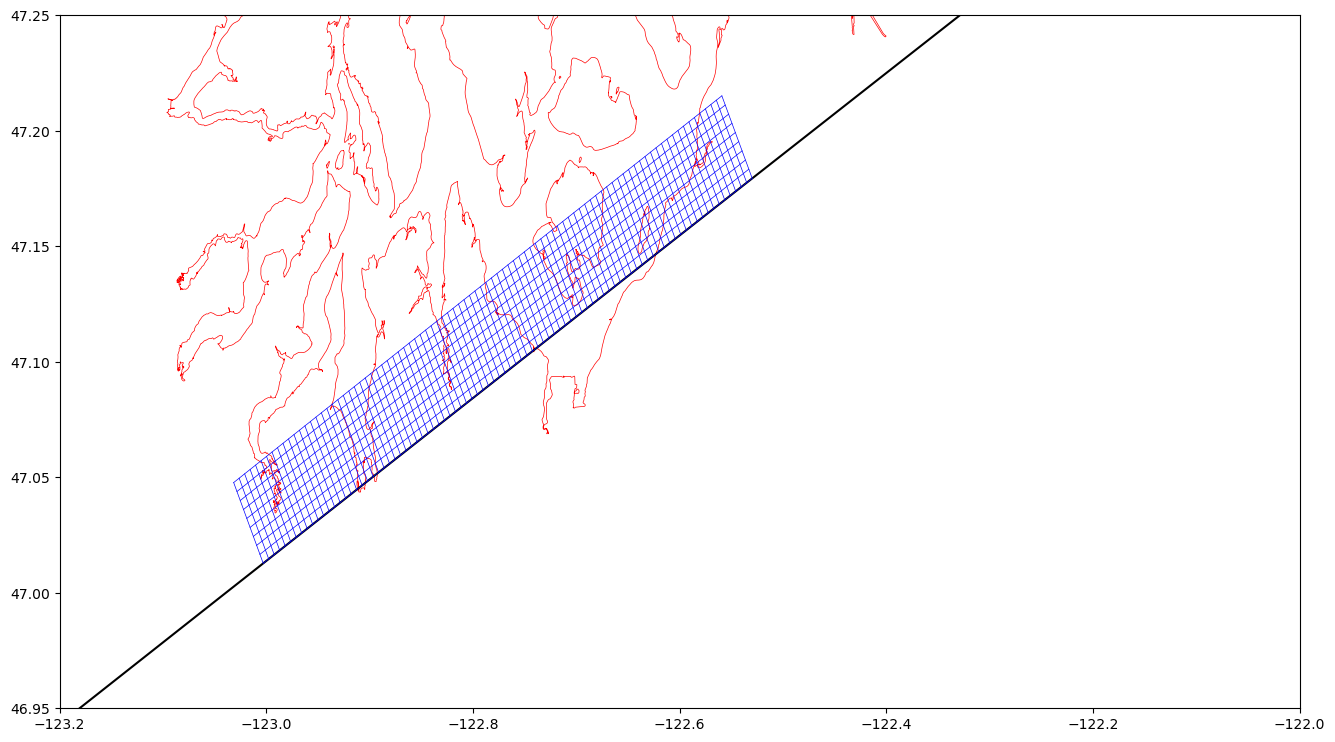

In [15]:
glamf, gphif = ssc_201702_coords.glamf[0], ssc_201702_coords.gphif[0]

fig, ax = plt.subplots(1, 1, figsize=(16, 9))
ax.plot(coastline[:, 0], coastline[:, 1], color="red", linewidth=0.5)
ax.plot(rivers[:, 0], rivers[:, 1], color="red", linewidth=0.5)

# SalishSeaCast domain boundaries
ax.plot(glamf[0, :], gphif[0, :], color="black")  # south
ax.plot(glamf[:, 0], gphif[:, 0], color="black")  # west
ax.plot(glamf[-1, :], gphif[-1, :], color="black")  # north
ax.plot(glamf[:, -1], gphif[:, -1], color="black")  # east

ax.plot(glamf[:10, 80:170], gphif[:10, 80:170], color="blue", linewidth=0.5)
for row in range(10):
    ax.plot(glamf[row, 80:170], gphif[row, 80:170], color="blue", linewidth=0.5)

# South Puget Sound area
ax.set_xlim(-123.2, -122.0)
ax.set_ylim(46.95, 47.25)

Visualize the latitude steps of the grid:

In [16]:
(gphif[1:11, 80] - gphif[:10, 80]).data

array([0.00388555, 0.0038853 , 0.00388508, 0.00388488, 0.00388471,
       0.00388456, 0.00388443, 0.00388433, 0.00388425, 0.00388419])

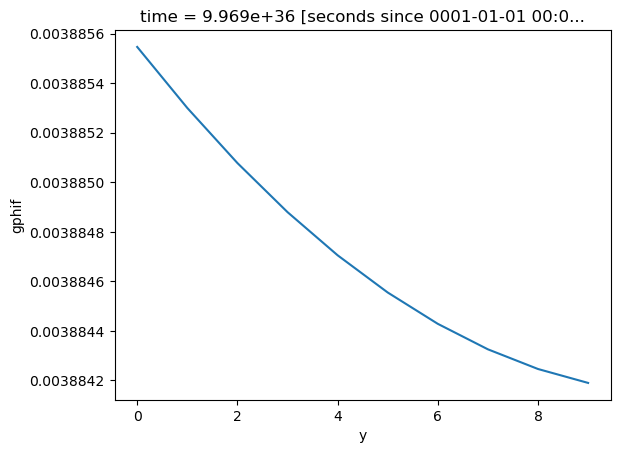

In [17]:
(gphif[1:11, 80] - gphif[:10, 80]).plot()

Fit a parabola to the first 3 points of a column of latitude grid steps:

In [18]:
def parabola(x, a, b, c):
    return a * x ** 2 + b * x + c

In [19]:
fit_params, pcov = scipy.optimize.curve_fit(
    parabola, numpy.linspace(2, 0, 3), (gphif[1:4, 80] - gphif[:3, 80]))

/tmp/ipykernel_254052/1599679458.py:1: OptimizeWarning: Covariance of the parameters could not be estimated
  fit_params, pcov = scipy.optimize.curve_fit(


In [20]:
(gphif[1:4, 80] - gphif[:3, 80]).data

array([0.00388555, 0.0038853 , 0.00388508])

In [21]:
[parabola(x, *fit_params) for x in numpy.linspace(2, 0, 3)]

[0.0038855463114418295, 0.003885299894142988, 0.0038850776303149814]

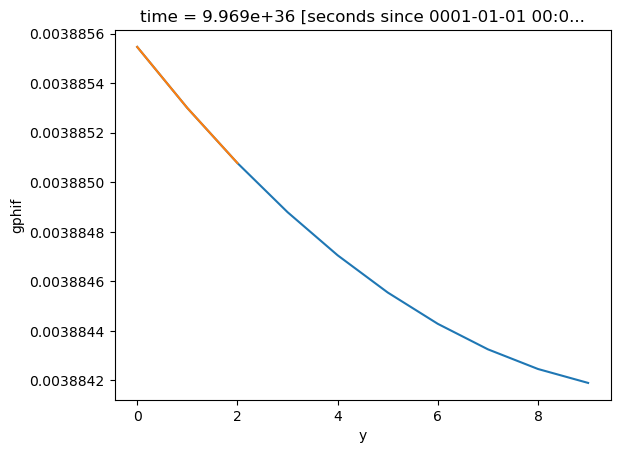

In [22]:
fig, ax = plt.subplots(1, 1)
(gphif[1:11, 80] - gphif[:10, 80]).plot(ax=ax)
ax.plot(numpy.linspace(2, 0, 3),
        [parabola(y, *fit_params) for y in numpy.linspace(0, 2, 3)])

So, we can use parabolic fits to calculate the latitude of the new grid points.

In [23]:
lat_fit_params, pcov = scipy.optimize.curve_fit(
    parabola, numpy.linspace(2, 0, 3), numpy.flip(gphif[:3, 80]))

lat_fit_params

/tmp/ipykernel_254052/2532276039.py:1: OptimizeWarning: Covariance of the parameters could not be estimated
  lat_fit_params, pcov = scipy.optimize.curve_fit(


array([-1.23209704e-07,  3.88566952e-03,  4.70127515e+01])

In [24]:
edge_lats = gphif[:3, 80].data

edge_lats

array([47.01275151, 47.01663705, 47.02052235])

In [25]:
new_lats = numpy.array(
    [parabola(x, *lat_fit_params) for x in numpy.linspace(-1, -11, 10)]
)

new_lats

array([47.00886571, 47.00454788, 47.00022974, 46.99591129, 46.99159254,
       46.98727349, 46.98295413, 46.97863447, 46.9743145 , 46.96999423])

Visualize the longitude steps of the grid:

In [26]:
(glamf[1:11, 80] - glamf[:10, 80]).data

array([-0.00317548, -0.00317551, -0.00317556, -0.00317563, -0.00317571,
       -0.00317582, -0.00317595, -0.0031761 , -0.00317626, -0.00317645])

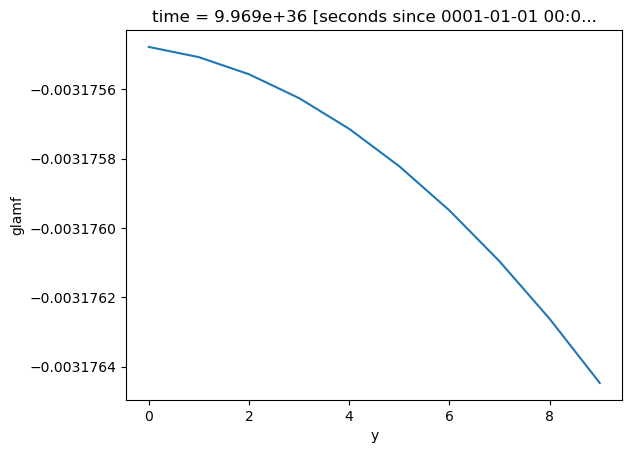

In [27]:
(glamf[1:11, 80] - glamf[:10, 80]).plot()

Fit a parabola to the first 3 points of a column of longitude grid steps:

In [28]:
fit_params, pcov = scipy.optimize.curve_fit(
    parabola, numpy.linspace(2, 0, 3), (glamf[1:4, 80] - glamf[:3, 80]))

/tmp/ipykernel_254052/3954364903.py:1: OptimizeWarning: Covariance of the parameters could not be estimated
  fit_params, pcov = scipy.optimize.curve_fit(


In [29]:
(glamf[1:4, 80] - glamf[:3, 80]).data

array([-0.00317548, -0.00317551, -0.00317556])

In [30]:
[parabola(x, *fit_params) for x in numpy.linspace(2, 0, 3)]

[-0.0031754782904184547, -0.003175507854066008, -0.003175557096454895]

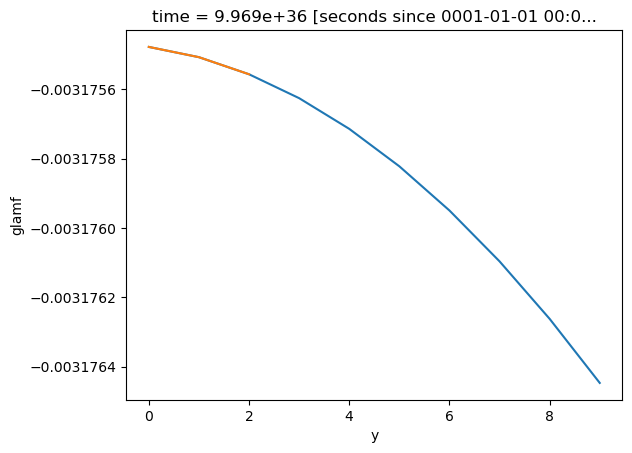

In [31]:
fig, ax = plt.subplots(1, 1)
(glamf[1:11, 80] - glamf[:10, 80]).plot(ax=ax)
ax.plot(numpy.linspace(2, 0, 3),
        [parabola(x, *fit_params) for x in numpy.linspace(0, 2, 3)])

So, we can use parabolic fits to calculate the longitude of the new grid points.

In [32]:
lon_fit_params, pcov = scipy.optimize.curve_fit(
    parabola, numpy.linspace(2, 0, 3), numpy.flip(glamf[:3, 80]))

lon_fit_params

/tmp/ipykernel_254052/2944064237.py:1: OptimizeWarning: Covariance of the parameters could not be estimated
  lon_fit_params, pcov = scipy.optimize.curve_fit(


array([-1.47839780e-08, -3.17546350e-03, -1.23002955e+02])

In [33]:
edge_lons = glamf[:3, 80].data

edge_lons

array([-123.00295542, -123.0061309 , -123.00930641])

In [34]:
new_lons = numpy.array(
    [parabola(x, *lon_fit_params) for x in numpy.linspace(-1, -11, 10)]
)

new_lons

array([-122.99977997, -122.99625173, -122.99272353, -122.98919536,
       -122.98566722, -122.98213913, -122.97861107, -122.97508305,
       -122.97155506, -122.96802711])

Visualize the new grid points with the 201702 grid:

(46.95, 47.25)

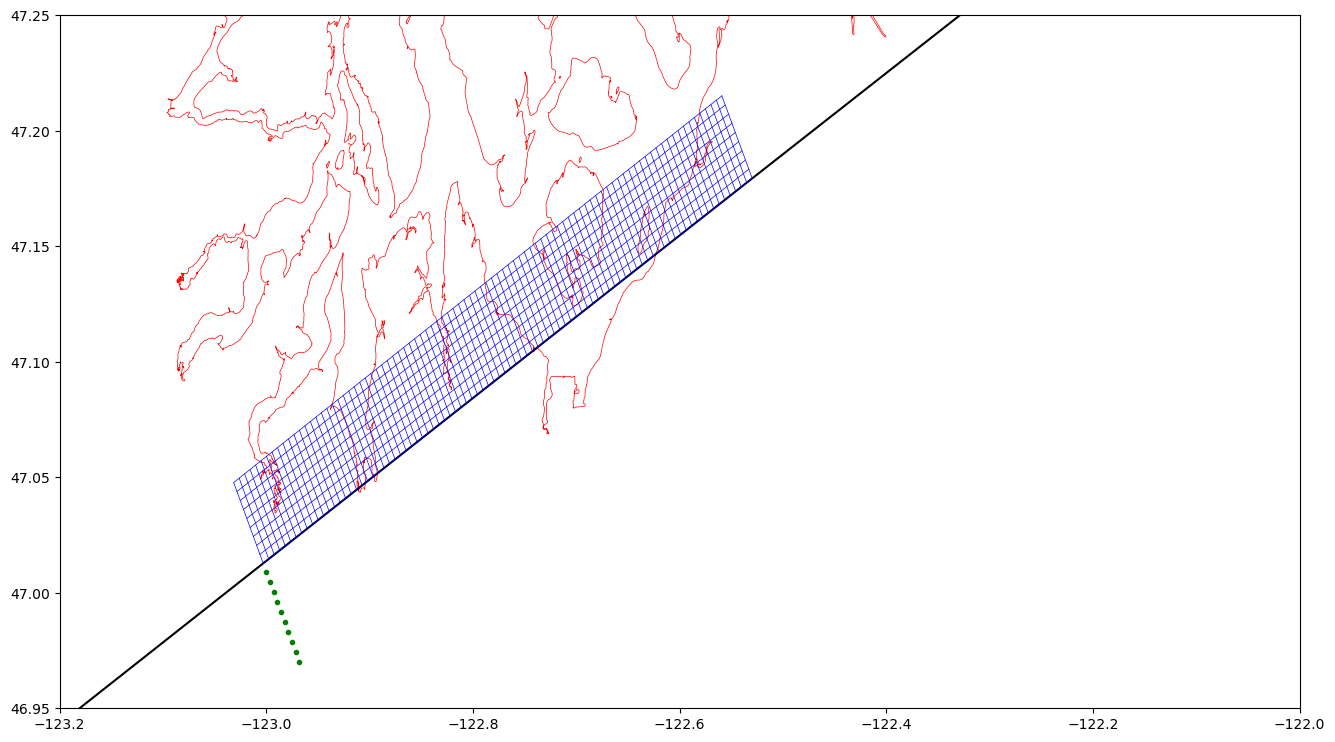

In [35]:
glamf, gphif = ssc_201702_coords.glamf[0], ssc_201702_coords.gphif[0]

fig, ax = plt.subplots(1, 1, figsize=(16, 9))
ax.plot(coastline[:, 0], coastline[:, 1], color="red", linewidth=0.5)
ax.plot(rivers[:, 0], rivers[:, 1], color="red", linewidth=0.5)

# SalishSeaCast domain boundaries
ax.plot(glamf[0, :], gphif[0, :], color="black")  # south
ax.plot(glamf[:, 0], gphif[:, 0], color="black")  # west
ax.plot(glamf[-1, :], gphif[-1, :], color="black")  # north
ax.plot(glamf[:, -1], gphif[:, -1], color="black")  # east

ax.plot(glamf[:10, 80:170], gphif[:10, 80:170], color="blue", linewidth=0.5)
for row in range(10):
    ax.plot(glamf[row, 80:170], gphif[row, 80:170], color="blue", linewidth=0.5)
ax.scatter(new_lons, new_lats, color="green", marker=".")

# South Puget Sound area
ax.set_xlim(-123.2, -122.0)
ax.set_ylim(46.95, 47.25)

Function to calculate new coordinate variable values using parabolic fits
for 10 new grid cells at the bottom of the grid;
i.e. `y = [-1, -2, ..., -11]`.
This is a generalization of the above prototype calculations to the pairs of 
x and y direction variables,`glam[tuvf]` and `gphi[tuvf]`.

In [36]:
def calc_new_x_y_vars(x_var, y_var, x):
    # parabola function form that we will use for fitting
    def parabola(coord, a, b, c):
        return a * coord ** 2 + b * coord + c

    with warnings.catch_warnings():
        # suppress the `OptimizeWarning: Covariance of the parameters could not be estimated`
        # warning
        warnings.simplefilter("ignore")
        lon_fit_params, _ = scipy.optimize.curve_fit(
            parabola, numpy.linspace(2, 0, 3), numpy.flip(x_var[:3, x])
        )
    new_vals = numpy.array(
        [parabola(x, *lon_fit_params) for x in numpy.linspace(-1, -11, 10)]
    )
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        lat_fit_params, pcov = scipy.optimize.curve_fit(
            parabola, numpy.linspace(2, 0, 3), numpy.flip(y_var[:3, x])
        )
    new_y_vals = numpy.array(
        [parabola(x, *lat_fit_params) for x in numpy.linspace(-1, -11, 10)]
    )
    # flip the arrays of new values so that they are ready to be prepended to the grid variable
    # arrays that they were calculated from
    return numpy.flip(new_vals, axis=0), numpy.flip(new_y_vals, axis=0)

Reproduce the figure above to test:

CPU times: user 317 ms, sys: 4.08 ms, total: 321 ms
Wall time: 321 ms


(46.95, 47.25)

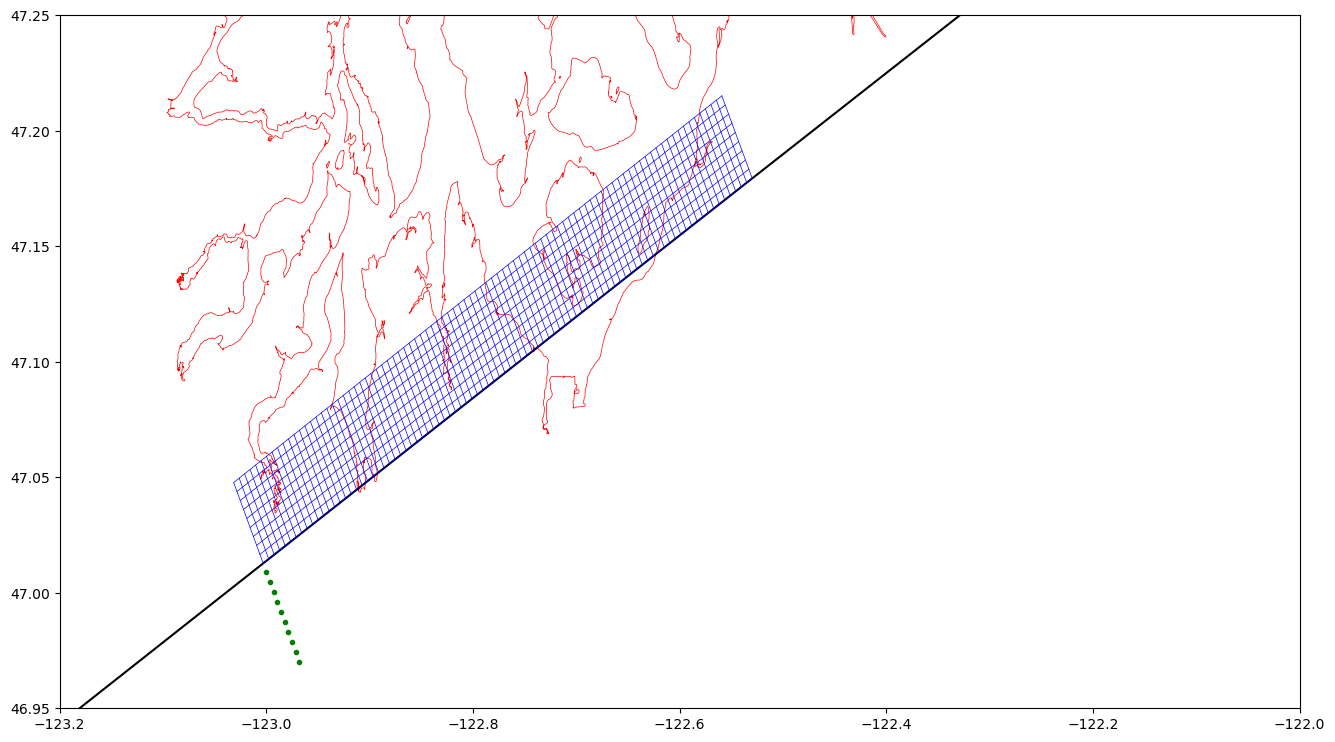

In [37]:
%%time
glamf, gphif = ssc_201702_coords.glamf[0], ssc_201702_coords.gphif[0]

fig, ax = plt.subplots(1, 1, figsize=(16, 9))
ax.plot(coastline[:, 0], coastline[:, 1], color="red", linewidth=0.5)
ax.plot(rivers[:, 0], rivers[:, 1], color="red", linewidth=0.5)

# SalishSeaCast domain boundaries
ax.plot(glamf[0, :], gphif[0, :], color="black")  # south
ax.plot(glamf[:, 0], gphif[:, 0], color="black")  # west
ax.plot(glamf[-1, :], gphif[-1, :], color="black")  # north
ax.plot(glamf[:, -1], gphif[:, -1], color="black")  # east

new_glamf, new_gphif = calc_new_x_y_vars(glamf, gphif, 80)

ax.plot(glamf[:10, 80:170], gphif[:10, 80:170], color="blue", linewidth=0.5)
for row in range(10):
    ax.plot(glamf[row, 80:170], gphif[row, 80:170], color="blue", linewidth=0.5)
ax.scatter(new_glamf, new_gphif, color="green", marker=".")

# South Puget Sound area
ax.set_xlim(-123.2, -122.0)
ax.set_ylim(46.95, 47.25)

Now, loop over a range of `x` and plot the new grid cells:

CPU times: user 1.93 s, sys: 35.9 ms, total: 1.97 s
Wall time: 1.97 s


(46.95, 47.25)

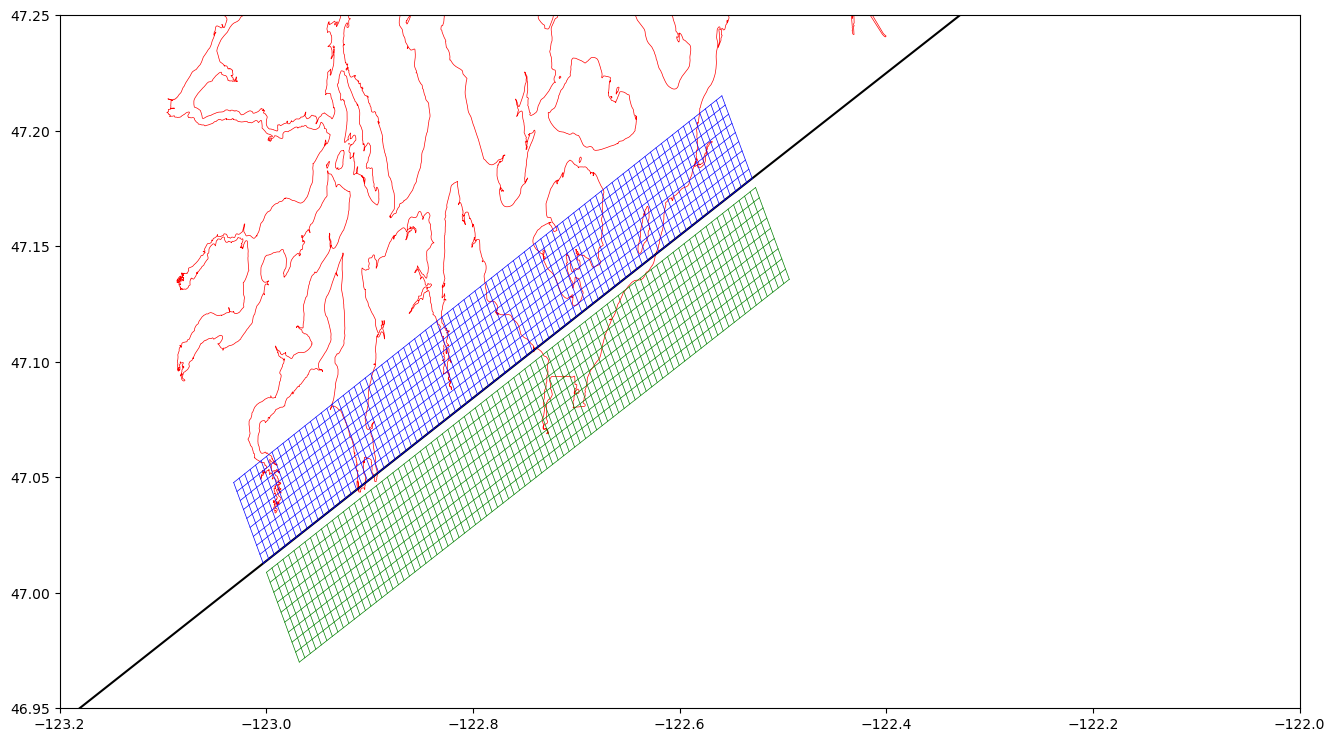

In [38]:
%%time
glamf, gphif = ssc_201702_coords.glamf[0], ssc_201702_coords.gphif[0]

fig, ax = plt.subplots(1, 1, figsize=(16, 9))
ax.plot(coastline[:, 0], coastline[:, 1], color="red", linewidth=0.5)
ax.plot(rivers[:, 0], rivers[:, 1], color="red", linewidth=0.5)

# SalishSeaCast domain boundaries
ax.plot(glamf[0, :], gphif[0, :], color="black")  # south
ax.plot(glamf[:, 0], gphif[:, 0], color="black")  # west
ax.plot(glamf[-1, :], gphif[-1, :], color="black")  # north
ax.plot(glamf[:, -1], gphif[:, -1], color="black")  # east

grid_extension_shape = (10, glamf.shape[1])
new_grid = {
    "glamf": numpy.empty(grid_extension_shape),
    "gphif": numpy.empty(grid_extension_shape),
}
for x in range(80, 170 + 1):
    new_grid["glamf"][:, x], new_grid["gphif"][:, x] = calc_new_x_y_vars(glamf, gphif, x)

ax.plot(glamf[:10, 80:170], gphif[:10, 80:170], color="blue", linewidth=0.5)
ax.plot(new_grid["glamf"][:10, 80:170], new_grid["gphif"][:10, 80:170], color="green",
        linewidth=0.5)
for row in range(10):
    ax.plot(glamf[row, 80:170], gphif[row, 80:170], color="blue", linewidth=0.5)
    ax.plot(new_grid["glamf"][row, 80:170], new_grid["gphif"][row, 80:170], color="green",
            linewidth=0.5)

# South Puget Sound area
ax.set_xlim(-123.2, -122.0)
ax.set_ylim(46.95, 47.25)

Time the calculation of all the new `glamf` and `gphif` values without visualization:

In [39]:
%%time
grid_extension_shape = (10, ssc_201702_coords.glamf[0].shape[1])
new_grid = {
    "glamf": numpy.empty(grid_extension_shape),
    "gphif": numpy.empty(grid_extension_shape),
}
for x in range(grid_extension_shape[1]):
    new_grid["glamf"][:, x], new_grid["gphif"][:, x] = calc_new_x_y_vars(
        ssc_201702_coords.glamf[0],
        ssc_201702_coords.gphif[0],
        x)

CPU times: user 7.15 s, sys: 92.2 ms, total: 7.24 s
Wall time: 7.24 s


~7 seconds per variable pair is fast enough that it is not worth trying to vectorize
the calculations in `calc_new_lon_lat_vars()` to eliminate the loop over `x`.

Calculate all the new grid variable values to extend the grid 10 cells at the bottom:

In [40]:
%%time
grid_extension_shape = (10, ssc_201702_coords.glamf[0].shape[1])
grid_vars = (
    "glamf", "gphif",
    "glamt", "gphit",
    "glamu", "gphiu",
    "glamv", "gphiv",
)
new_grid = {
    var: numpy.empty(grid_extension_shape)
    for var in grid_vars
}
for x_var, y_var in zip(grid_vars, grid_vars[1:]):
    for x in range(grid_extension_shape[1]):
        new_grid[x_var][:, x], new_grid[y_var][:, x] = calc_new_x_y_vars(
            ssc_201702_coords[x_var][0],
            ssc_201702_coords[y_var][0],
            x
        )
new_grid["nav_lon"], new_grid["nav_lat"] = new_grid["glamt"], new_grid["gphit"]

CPU times: user 55.1 s, sys: 732 ms, total: 55.9 s
Wall time: 56 s


Create `glamf` and `gphif` arrays for the new coordinates by prepending the `new_grid` arrays to those
from `ssc_201702_coords`.
Visualize the south Puget Sound patch of the new coordinates.

(46.95, 47.25)

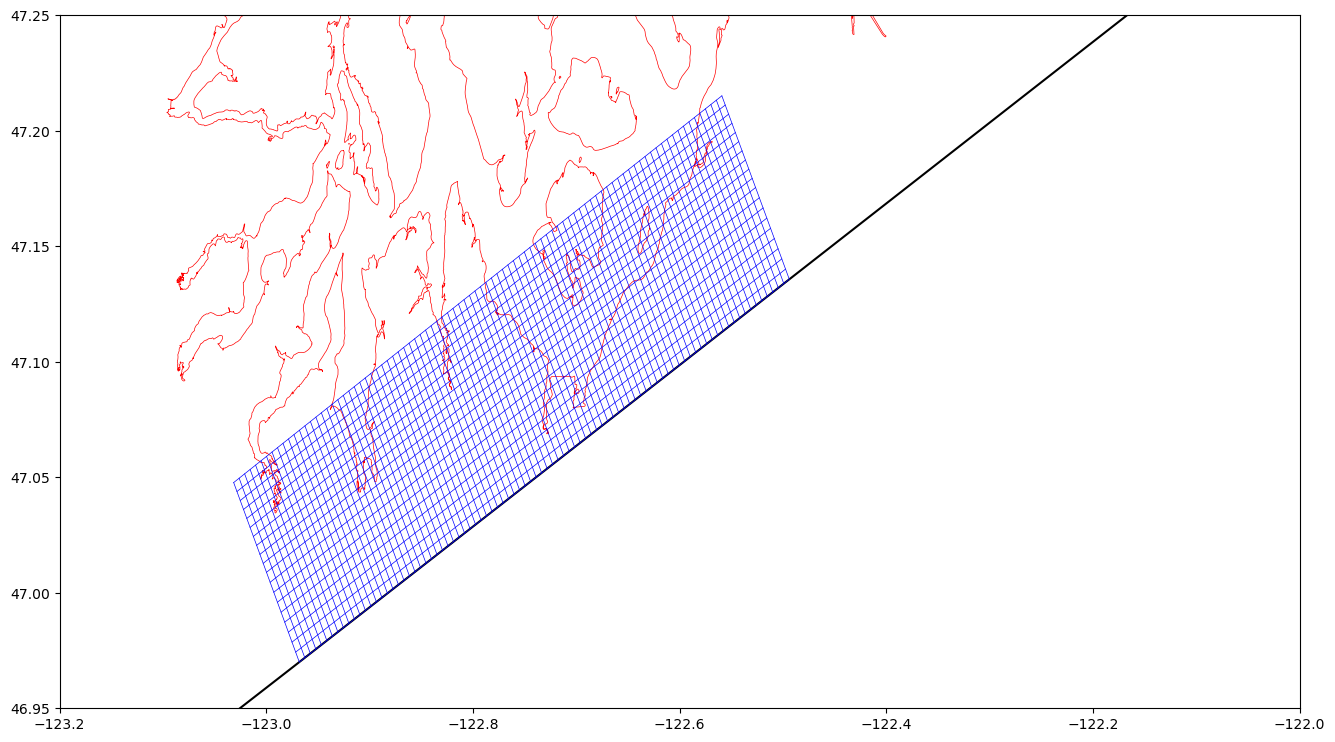

In [41]:
glamf = numpy.insert(ssc_201702_coords.glamf[0], 0, new_grid["glamf"], axis=0)
gphif = numpy.insert(ssc_201702_coords.gphif[0], 0, new_grid["gphif"], axis=0)

fig, ax = plt.subplots(1, 1, figsize=(16, 9))
ax.plot(coastline[:, 0], coastline[:, 1], color="red", linewidth=0.5)
ax.plot(rivers[:, 0], rivers[:, 1], color="red", linewidth=0.5)

# SalishSeaCast domain boundaries
ax.plot(glamf[0, :], gphif[0, :], color="black")  # south
ax.plot(glamf[:, 0], gphif[:, 0], color="black")  # west
ax.plot(glamf[-1, :], gphif[-1, :], color="black")  # north
ax.plot(glamf[:, -1], gphif[:, -1], color="black")  # east

ax.plot(glamf[:20, 80:170], gphif[:20, 80:170], color="blue", linewidth=0.5)
for row in range(20):
    ax.plot(glamf[row, 80:170], gphif[row, 80:170], color="blue", linewidth=0.5)

# South Puget Sound area
ax.set_xlim(-123.2, -122.0)
ax.set_ylim(46.95, 47.25)

### Start 202405 Cordinates Dataset

Dataset variable numpy arrays:

In [134]:
new_arrays = {
    "nav_lon": numpy.concatenate((ssc_201702_coords.nav_lon, new_grid["nav_lon"]), axis=0),
    "nav_lat": numpy.concatenate((ssc_201702_coords.nav_lat, new_grid["nav_lat"]), axis=0),
}
new_arrays.update(
    {
        grid_var: numpy.concatenate((ssc_201702_coords[grid_var], numpy.expand_dims(new_grid[grid_var], axis=0)), axis=1).astype("float32")
        for grid_var in grid_vars
    }
)

Dataset coordinates:

In [135]:
time_value = numpy.array([0], dtype=numpy.float32)
time_ccord = xarray.DataArray(
    name="time",
    data=time_value,
    coords={"time": time_value},
    dims=["time"],
    attrs={
        "standard_name": "time",
        "long_name": "Time Axis",
        "time_origin": "2024-05-01",
        "comment": "NEMO requires a time variable for most coordinate arrays, but its value is irrelevant",
        # encoding provides time_origin and units when dataset is written to netCDF4 file
    },
)

y_indices = numpy.arange(new_arrays["nav_lon"].shape[0], dtype=int)
y_coord = xarray.DataArray(
    name="y",
    data=y_indices,
    coords={"y": y_indices},
    dims=["y"],
    attrs={
        "standard_name": "y",
        "long_name": "Y",
        "units": "count",
        "comment": "grid indices in the model y-direction",
    },
)

x_indices = numpy.arange(new_arrays["nav_lon"].shape[1], dtype=int)
x_coord = xarray.DataArray(
    name="x",
    data=x_indices,
    coords={"x": x_indices},
    dims=["x"],
    attrs={
        "standard_name": "x",
        "long_name": "X",
        "units": "count",
        "comment": "grid indices in the model x-direction",
    },
)


Dataset variables:

In [136]:
data_vars = {
    "nav_lon": xarray.DataArray(
        name="nav_lon",
        data=new_arrays["nav_lon"],
        coords={
            "y": y_coord,
            "x": x_coord,
        },
        dims=["y", "x"],
        attrs={
            "standard_name": "longitude",
            "long_name": "Longitude",
            "units": "degrees_east",
            "comment": "at T grid points; identical to glamt"
        },
    ),
    "nav_lat": xarray.DataArray(
        name="nav_lat",
        data=new_arrays["nav_lat"],
        coords={
            "y": y_coord,
            "x": x_coord,
        },
        dims=["y", "x"],
        attrs={
            "standard_name": "latitude",
            "long_name": "Latitude",
            "units": "degrees_north",
            "comment": "at T grid points; identical to gphit"
        },
    ),
    "glamt": xarray.DataArray(
        name="glamt",
        data=new_arrays["glamt"],
        coords={
            "time": time_ccord,
            "y": y_coord,
            "x": x_coord,
        },
        dims=["time", "y", "x"],
        attrs={
            "standard_name": "glamt",
            "long_name": "Longitude of T-grid Points",
            "units": "degrees_east",
            "comment": "identical to nav_lon"
        },
    ),
    "glamu": xarray.DataArray(
        name="glamu",
        data=new_arrays["glamu"],
        coords={
            "time": time_ccord,
            "y": y_coord,
            "x": x_coord,
        },
        dims=["time", "y", "x"],
        attrs={
            "standard_name": "glamu",
            "long_name": "Longitude of U-grid Points",
            "units": "degrees_east",
        },
    ),
    "glamv": xarray.DataArray(
        name="glamv",
        data=new_arrays["glamv"],
        coords={
            "time": time_ccord,
            "y": y_coord,
            "x": x_coord,
        },
        dims=["time", "y", "x"],
        attrs={
            "standard_name": "glamv",
            "long_name": "Longitude of V-grid Points",
            "units": "degrees_east",
        },
    ),
    "glamf": xarray.DataArray(
        name="glamf",
        data=new_arrays["glamf"],
        coords={
            "time": time_ccord,
            "y": y_coord,
            "x": x_coord,
        },
        dims=["time", "y", "x"],
        attrs={
            "standard_name": "glamf",
            "long_name": "Longitude of Vorticity-grid Points",
            "units": "degrees_east",
        },
    ),
    "gphit": xarray.DataArray(
        name="gphit",
        data=new_arrays["gphit"],
        coords={
            "time": time_ccord,
            "y": y_coord,
            "x": x_coord,
        },
        dims=["time", "y", "x"],
        attrs={
            "standard_name": "gphit",
            "long_name": "Latitude of T-grid Points",
            "units": "degrees_north",
            "comment": "identical to nav_lat"
        },
    ),
    "gphiu": xarray.DataArray(
        name="gphiu",
        data=new_arrays["gphiu"],
        coords={
            "time": time_ccord,
            "y": y_coord,
            "x": x_coord,
        },
        dims=["time", "y", "x"],
        attrs={
            "standard_name": "gphiu",
            "long_name": "Latitude of U-grid Points",
            "units": "degrees_north",
        },
    ),
    "gphiv": xarray.DataArray(
        name="gphiv",
        data=new_arrays["gphiv"],
        coords={
            "time": time_ccord,
            "y": y_coord,
            "x": x_coord,
        },
        dims=["time", "y", "x"],
        attrs={
            "standard_name": "gphiv",
            "long_name": "Latitude of V-grid Points",
            "units": "degrees_north",
        },
    ),
    "gphif": xarray.DataArray(
        name="gphif",
        data=new_arrays["gphif"],
        coords={
            "time": time_ccord,
            "y": y_coord,
            "x": x_coord,
        },
        dims=["time", "y", "x"],
        attrs={
            "standard_name": "gphif",
            "long_name": "Latitude of Vorticity-grid Points",
            "units": "degrees_north",
        },
    ),
}

Coordinates dataset:

In [137]:
djl_202405_coords = xarray.Dataset(
    data_vars=data_vars,
        coords={
            "time": time_ccord,
            "y": y_coord,
            "x": x_coord,
        },
    attrs={
        "name": "coordinates_SalishSeaCast_202405",
        "description": (
            "SalishSeaCast coordinates version 202405; extended from version 201702 to include \n"
            "the south end of Puget Sound"
        ),
        "history": (
            f"{arrow.now('local').format('YYYY-MM-DD HH:mm ZZ')}: Created by \n"
            f"https://github.com/SalishSeaCast/analysis-doug/blob/main/notebooks/2xrez-202111/coordinates.ipynb"
        )
    },
)

djl_202405_coords

<xarray.Dataset> Size: 17MB
Dimensions:  (y: 908, x: 398, time: 1)
Coordinates:
  * y        (y) int64 7kB 0 1 2 3 4 5 6 7 8 ... 900 901 902 903 904 905 906 907
  * x        (x) int64 3kB 0 1 2 3 4 5 6 7 8 ... 390 391 392 393 394 395 396 397
  * time     (time) float32 4B 0.0
Data variables:
    nav_lon  (y, x) float64 3MB -123.4 -123.4 -123.4 ... -121.3 -121.3 -121.3
    nav_lat  (y, x) float64 3MB 46.86 46.86 46.86 46.87 ... 47.59 47.6 47.6
    glamt    (time, y, x) float32 1MB -123.4 -123.4 -123.4 ... -121.3 -121.3
    glamu    (time, y, x) float32 1MB -123.4 -123.4 -123.4 ... -121.3 -121.3
    glamv    (time, y, x) float32 1MB -123.4 -123.4 -123.4 ... -121.3 -121.3
    glamf    (time, y, x) float32 1MB -123.4 -123.4 -123.4 ... -121.3 -121.3
    gphit    (time, y, x) float32 1MB 46.86 46.86 46.86 ... 47.59 47.6 47.6
    gphiu    (time, y, x) float32 1MB 46.86 46.86 46.86 ... 47.59 47.6 47.6
    gphiv    (time, y, x) float32 1MB 46.86 46.86 46.87 46.87 ... 47.6 47.6 47.6
    gphif    (time, y, x) float32 1MB 46.86 46.86 46.87 46.87 ... 47.6 47.6 47.6
Attributes:
    name:         coordinates_SalishSeaCast_202405
    description:  SalishSeaCast coordinates version 202405; extended from ver...
    history:      2024-05-15 17:45 -07:00: Created by \nhttps://github.com/Sa...

### Grid Spacing Arrays (`e1[tuvf]` and `e2[tuvf]`)

Calculate grid spacing arrays from `glam[tuvf]` and `gphi[tuvf]` arrays using the haversine spherical trigonometry formula.
Copy the `haversine()` function from `tools/SalishSeaTools/salishsea_tools/geo_tools.py` to avoid having to include all of the
`SalishSeaTools` dependencies in our environment. 

In [42]:
def haversine(lon1, lat1, lon2, lat2):
    """Calculate the great-circle distance in kilometers between two points
    on a sphere from their longitudes and latitudes.

    Reference: https://www.movable-type.co.uk/scripts/latlong.html

    :arg lon1: Longitude of point 1.
    :type lon1: float or :py:class:`numpy.ndarray`

    :arg lat1: Latitude of point 1.
    :type lat1: float or :py:class:`numpy.ndarray`

    :arg lon2: Longitude of point 2.
    :type lon2: float or :py:class:`numpy.ndarray`

    :arg lat2: Latitude of point 2.
    :type lat2: float or :py:class:`numpy.ndarray`

    :returns: Great-circle distance between two points in km
    :rtype: float or :py:class:`numpy.ndarray`
    """
    lon1, lat1, lon2, lat2 = map(numpy.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = numpy.sin(dlat/2)**2 + numpy.cos(lat1) * numpy.cos(lat2) * numpy.sin(dlon/2)**2
    c = 2 * numpy.arcsin(numpy.sqrt(a))
    km = 6367 * c
    return km

![foo](e1e2t.png)

Based on the above image from https://www.mercator-ocean.eu/wp-content/uploads/2017/06/static_info.pdf,
the `e[12][tuvf]` values are calculated from the `g[lam|phi][tuvf]` values by:

* `e1t[j, i] = haversine(glamu[j, i], gphiu[j, i], glamu[j, i-1], gphiu[j, i-1])`

* `e1v[j, i] = haversine(glamf[j, i], gphif[j, i], glamf[j, i-1], gphif[j, i-1])`

* `e1u[j, i] = haversine(glamt[j, i], gphit[j, i], glamt[j, i+1], gphit[j, i+1])`

* `e1f[j, i] = haversine(glamv[j, i], gphiv[j, i], glamv[j, i+1], gphiv[j, i+1])`

* `e2t[j, i] = haversine(glamv[j, i], gphiv[j, i], glamv[j-1, i], gphiv[j-1, i])`

* `e2u[j, i] = haversine(glamf[j, i], gphif[j, i], glamf[j-1, i], gphif[j-1, i])`

* `e2v[j, i] = haversine(glamt[j, i], gphit[j, i], glamt[j+1, i], gphit[j+1, i])`

* `e2f[j, i] = haversine(glamu[j, i], gphiu[j, i], glamu[j+1, i], gphiu[j+1, i])`

Note that the figure simplifies the grid cell shape to a square.
In reality, grid cells are quadrilaterals with different lengths on all 4 sides.
So, `e1t != e1v` despite how it looks in the figure.

Check the `haversine()` implementation of the above formulas:

e1t: correct

In [43]:
ssc_201702_coords.e1t[0, :3, 80].data

array([453.6108306 , 453.56510192, 453.51948765])

In [44]:
calc_e1t = haversine(ssc_201702_coords.glamu[0, :3, 80], ssc_201702_coords.gphiu[0, :3, 80], ssc_201702_coords.glamu[0, :3, 79], ssc_201702_coords.gphiu[0, :3, 79]).data * 1000

calc_e1t

array([453.6108306 , 453.56510192, 453.51948765])

In [45]:
numpy.testing.assert_array_equal(calc_e1t, ssc_201702_coords.e1t[0, :3, 80].data)

e1v: correct

In [46]:
ssc_201702_coords.e1v[0, :3, 80].data

array([453.58795086, 453.5422794 , 453.49672333])

In [47]:
calc_e1v = haversine(ssc_201702_coords.glamf[0, :3, 80], ssc_201702_coords.gphif[0, :3, 80], ssc_201702_coords.glamf[0, :3, 79], ssc_201702_coords.gphif[0, :3, 79]).data * 1000

calc_e1v

array([453.58795086, 453.5422794 , 453.49672333])

In [48]:
numpy.testing.assert_array_equal(calc_e1v, ssc_201702_coords.e1v[0, :3, 80].data)

e1u: correct

In [49]:
ssc_201702_coords.e1u[0, :3, 80].data

array([453.60286875, 453.55717844, 453.51160097])

In [50]:
calc_e1u = haversine(ssc_201702_coords.glamt[0, :3, 80], ssc_201702_coords.gphit[0, :3, 80], ssc_201702_coords.glamt[0, :3, 81], ssc_201702_coords.gphit[0, :3, 81]).data * 1000

calc_e1u

array([453.60286875, 453.55717844, 453.51160097])

In [51]:
numpy.testing.assert_array_equal(calc_e1v, ssc_201702_coords.e1v[0, :3, 80].data)

e1f: correct

In [52]:
ssc_201702_coords.e1f[0, :3, 80].data

array([453.5800084 , 453.53437452, 453.48885445])

In [53]:
calc_e1f = haversine(ssc_201702_coords.glamv[0, :3, 80], ssc_201702_coords.gphiv[0, :3, 80], ssc_201702_coords.glamv[0, :3, 81], ssc_201702_coords.gphiv[0, :3, 81]).data * 1000

calc_e1f

array([453.5800084 , 453.53437452, 453.48885445])

In [54]:
numpy.testing.assert_array_equal(calc_e1f, ssc_201702_coords.e1f[0, :3, 80].data)

e2t: correct

In [55]:
ssc_201702_coords.e2t[0, 1:4, 80].data

array([494.18606413, 494.15478767, 494.12662025])

In [56]:
calc_e2t = haversine(ssc_201702_coords.glamv[0, 1:4, 80], ssc_201702_coords.gphiv[0, 1:4, 80], ssc_201702_coords.glamv[0, :3, 80], ssc_201702_coords.gphiv[0, :3, 80]).data * 1000

calc_e2t

array([494.18606413, 494.15478767, 494.12662025])

In [57]:
numpy.testing.assert_array_equal(calc_e2t, ssc_201702_coords.e2t[0, 1:4, 80].data)

e2u: correct

In [58]:
ssc_201702_coords.e2u[0, 1:4, 80].data

array([494.28846711, 494.25711606, 494.22883508])

In [59]:
calc_e2u = haversine(ssc_201702_coords.glamf[0, 1:4, 80], ssc_201702_coords.gphif[0, 1:4, 80], ssc_201702_coords.glamf[0, :3, 80], ssc_201702_coords.gphif[0, :3, 80]).data * 1000

calc_e2u

array([494.28846711, 494.25711606, 494.22883508])

In [60]:
numpy.testing.assert_array_equal(calc_e2u, ssc_201702_coords.e2u[0, 1:4, 80].data)

e2v: correct

In [61]:
ssc_201702_coords.e2v[0, :3, 80].data

array([494.20248039, 494.1696477 , 494.13992745])

In [62]:
calc_e2v = haversine(ssc_201702_coords.glamt[0, :3, 80], ssc_201702_coords.gphit[0, :3, 80], ssc_201702_coords.glamt[0, 1:4, 80], ssc_201702_coords.gphit[0, 1:4, 80]).data * 1000

calc_e2v

array([494.20248039, 494.1696477 , 494.13992745])

In [63]:
numpy.testing.assert_array_equal(calc_e2v, ssc_201702_coords.e2v[0, :3, 80].data)

e2f: correct

In [64]:
ssc_201702_coords.e2f[0, :3, 80].data

array([494.30491092, 494.27202314, 494.24220878])

In [65]:
calc_e2f = haversine(ssc_201702_coords.glamu[0, 1:4, 80], ssc_201702_coords.gphiu[0, 1:4, 80], ssc_201702_coords.glamu[0, :3, 80], ssc_201702_coords.gphiu[0, :3, 80]).data * 1000

calc_e2f

array([494.30491092, 494.27202314, 494.24220878])

In [66]:
numpy.testing.assert_array_equal(calc_e2f, ssc_201702_coords.e2f[0, :3, 80].data)